# **IMPORT MODULES**

In [69]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

In [70]:
# ONLY USE CPU FOR TRAINING
# THIS IS A TEMPORARY FIX, SINCE GPU TRAINING IS GIVING ERRORS
# RUN THIS BEFORE IMPORTING TENSORFLOW
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [71]:
import tensorflow as tf
print(tf.__version__)

2.19.0


<br><br><br>
# **DATA PROCESSING**

In [72]:


# FD001 verisini oku
train = pd.read_csv(os.path.join("CMaps", "train_FD001.txt"), sep=" ", header=None)
train.drop(columns=[26, 27], inplace=True)  # Boş sütunları at
train.columns = ['unit', 'time'] + [f'op{i}' for i in range(1,4)] + [f'sensor{i}' for i in range(1,22)]

# Her motor için RUL hesapla
rul = train.groupby('unit')['time'].max().reset_index()
rul.columns = ['unit', 'max_time']
train = train.merge(rul, on='unit')
train['RUL'] = train['max_time'] - train['time']
train.drop('max_time', axis=1, inplace=True)

# Sensör seçimi (örnek)
sensor_cols = ['sensor2', 'sensor3', 'sensor4', 'sensor7', 'sensor8', 'sensor9', 'sensor11', 'sensor12', 'sensor13', 'sensor15', 'sensor17', 'sensor20', 'sensor21']

# Normalizasyon
scaler = MinMaxScaler()
train[sensor_cols] = scaler.fit_transform(train[sensor_cols])

train.head()


,unit,time,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,0.183735,0.406802,0.309757,14.62,...,0.205882,8138.62,0.363986,0.03,0.333333,2388,100.0,0.713178,0.724662,191
1,1,2,0.0019,-0.0003,100.0,518.67,0.283133,0.453019,0.352633,14.62,...,0.279412,8131.49,0.411312,0.03,0.333333,2388,100.0,0.666667,0.731014,190
2,1,3,-0.0043,0.0003,100.0,518.67,0.343373,0.369523,0.370527,14.62,...,0.220588,8133.23,0.357445,0.03,0.166667,2388,100.0,0.627907,0.621375,189
3,1,4,0.0007,0.0000,100.0,518.67,0.343373,0.256159,0.331195,14.62,...,0.294118,8133.83,0.166603,0.03,0.333333,2388,100.0,0.573643,0.662386,188
4,1,5,-0.0019,-0.0002,100.0,518.67,0.349398,0.257467,0.404625,14.62,...,0.235294,8133.80,0.402078,0.03,0.416667,2388,100.0,0.589147,0.704502,187


In [73]:
sequence_length = 30
features = train[sensor_cols + ['unit', 'RUL']]

X, y = [], []

# Produce windows
for unit in features['unit'].unique():
    unit_df = features[features['unit'] == unit]
    unit_data = unit_df[sensor_cols].values
    unit_rul = unit_df['RUL'].values
    
    for i in range(len(unit_data) - sequence_length + 1):
        X.append(unit_data[i:i+sequence_length])
        y.append(unit_rul[i + sequence_length - 1])  # pencerenin sonundaki RUL

X = np.array(X)
y = np.array(y)

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (17731, 30, 13), y shape: (17731,)


In [74]:


# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}")


Train shape: (14184, 30, 13), Validation shape: (3547, 30, 13)


<br><br><br>
# **TRAIN LSTM**

In [75]:
# LSTM model definition
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)  # Regression output
])

# Compile
model.compile(optimizer='adam', loss='mae', metrics=['mae'])

model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 30, 64)         │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,417 (126.63 KB)

 Trainable params: 32,417 (126.63 KB)

 Non-trainable params: 0 (0.00 B)

In [91]:
# Callbacks 
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


# TRAIN
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 50.5794 - mae: 50.5794 - val_loss: 50.1844 - val_mae: 50.1844
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 50.5237 - mae: 50.5237 - val_loss: 50.1970 - val_mae: 50.1970
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 50.5711 - mae: 50.5711 - val_loss: 50.1979 - val_mae: 50.1979
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 49.7211 - mae: 49.7211 - val_loss: 50.2056 - val_mae: 50.2056
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 50.2531 - mae: 50.2531 - val_loss: 50.2067 - val_mae: 50.2067
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 50.6632 - mae: 50.6632 - val_loss: 50.2101 - val_mae: 50.2101
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 49.4309 - mae: 49.4309 - val_loss: 36.2399 - val_mae: 36.2399
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 33.6664 - mae: 33.6664 - val_loss: 29.4014 - val_mae: 29.4014
Epoch 9/50
222/2

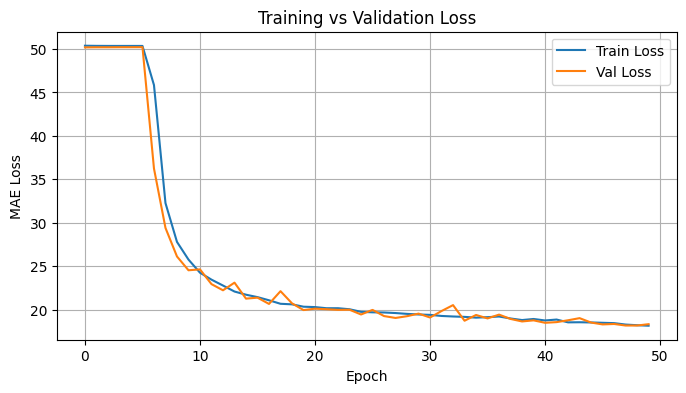

In [92]:
# Loss grafiklerini çiz
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


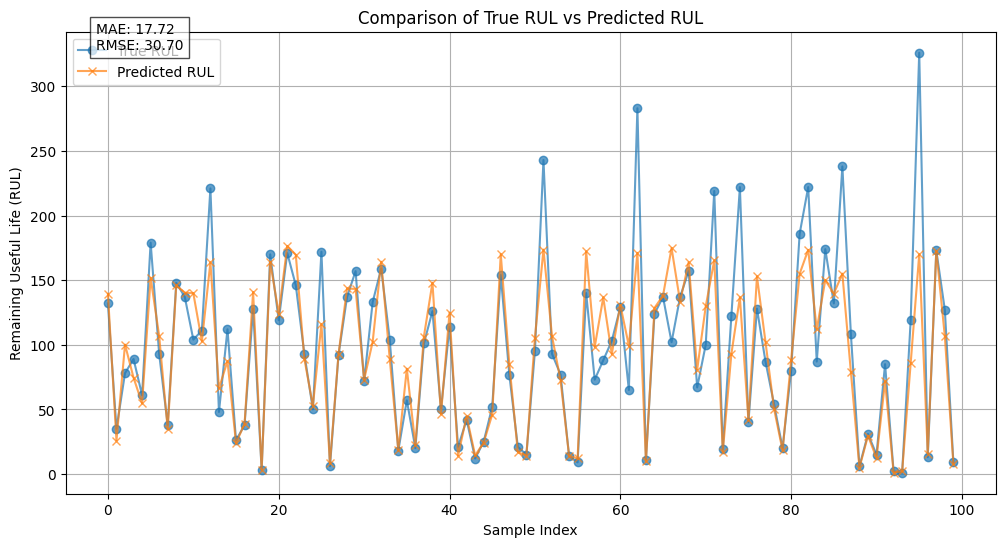

In [93]:
# Plot True RUL vs Normal Predictions for Validation Set
# Use validation data since we have ground truth labels

# Get predictions on validation set
val_predictions = model.predict(X_val)

# Select a subset of samples for clearer visualization
sample_size = 100
sample_indices = np.random.choice(len(X_val), sample_size, replace=False)

plt.figure(figsize=(12, 6))
plt.plot(y_val[sample_indices], label='True RUL', marker='o', linestyle='-', alpha=0.7)
plt.plot(val_predictions[sample_indices], label='Predicted RUL', marker='x', linestyle='-', alpha=0.7)
plt.title("Comparison of True RUL vs Predicted RUL")
plt.xlabel("Sample Index")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.grid(True)

# Calculate and display metrics
mae = np.mean(np.abs(y_val[sample_indices] - val_predictions[sample_indices].flatten()))
rmse = np.sqrt(np.mean((y_val[sample_indices] - val_predictions[sample_indices].flatten())**2))
plt.figtext(0.15, 0.85, f"MAE: {mae:.2f}\nRMSE: {rmse:.2f}", 
           bbox=dict(facecolor='white', alpha=0.7))

plt.show()

<br><br><br>
# **TRAIN GRU**

In [94]:
# GRU model definition
gru_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.GRU(64, return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(1)  # Regression output
])

# Compile
gru_model.compile(optimizer='adam', loss='mae', metrics=['mae'])

gru_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_6 (GRU)                     │ (None, 30, 64)         │        15,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,609 (96.13 KB)

 Trainable params: 24,609 (96.13 KB)

 Non-trainable params: 0 (0.00 B)

In [95]:
# Callbacks 
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# TRAIN GRU MODEL
gru_history = gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 89.4782 - mae: 89.4782 - val_loss: 81.5943 - val_mae: 81.5943
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 81.4707 - mae: 81.4707 - val_loss: 75.8534 - val_mae: 75.8534
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 75.6295 - mae: 75.6295 - val_loss: 70.9846 - val_mae: 70.9846
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 71.1639 - mae: 71.1639 - val_loss: 66.8166 - val_mae: 66.8166
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 66.6563 - mae: 66.6563 - val_loss: 63.3205 - val_mae: 63.3205
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 63.7166 - mae: 63.7166 - val_loss: 60.3815 - val_mae: 60.3815
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 61.0615 - mae: 61.0615 - val_loss: 57.9589 - val_mae: 57.9589
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 58.0454 - mae: 58.0454 - val_loss: 55.9914 - val_mae: 55.9914
Epoch 9/50
222/2

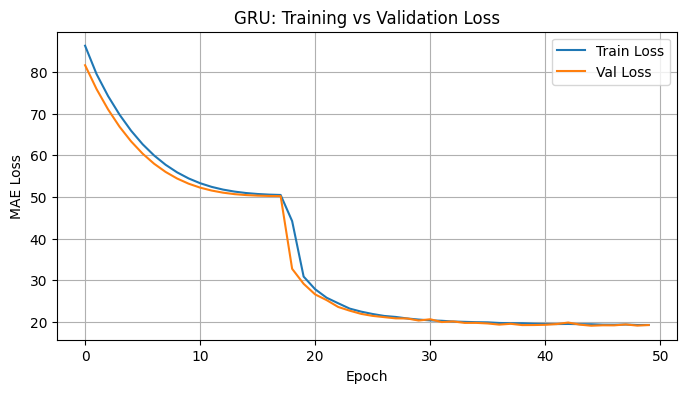

In [96]:
# Loss plot for GRU model
plt.figure(figsize=(8, 4))
plt.plot(gru_history.history['loss'], label='Train Loss')
plt.plot(gru_history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.title('GRU: Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


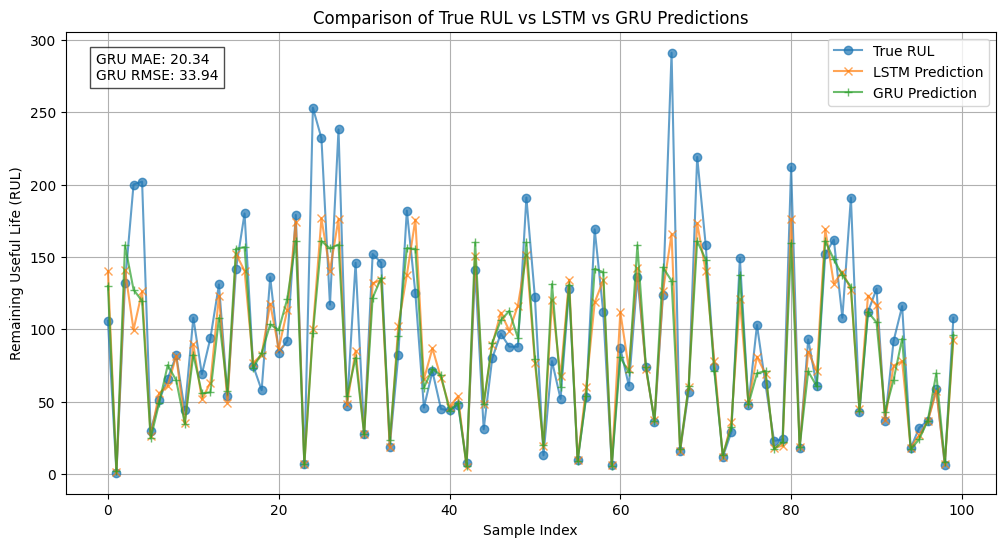

In [97]:
# Get predictions on validation set from GRU model
gru_val_predictions = gru_model.predict(X_val)

# Plot comparison with original model
sample_size = 100
sample_indices = np.random.choice(len(X_val), sample_size, replace=False)

plt.figure(figsize=(12, 6))
plt.plot(y_val[sample_indices], label='True RUL', marker='o', linestyle='-', alpha=0.7)
plt.plot(val_predictions[sample_indices], label='LSTM Prediction', marker='x', linestyle='-', alpha=0.7)
plt.plot(gru_val_predictions[sample_indices], label='GRU Prediction', marker='+', linestyle='-', alpha=0.7)
plt.title("Comparison of True RUL vs LSTM vs GRU Predictions")
plt.xlabel("Sample Index")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.grid(True)

# Calculate and display metrics for GRU
gru_mae = np.mean(np.abs(y_val[sample_indices] - gru_val_predictions[sample_indices].flatten()))
gru_rmse = np.sqrt(np.mean((y_val[sample_indices] - gru_val_predictions[sample_indices].flatten())**2))
plt.figtext(0.15, 0.80, f"GRU MAE: {gru_mae:.2f}\nGRU RMSE: {gru_rmse:.2f}", 
           bbox=dict(facecolor='white', alpha=0.7))

plt.show()

<br><br><br>
# **FGSM attack on LSTM**

In [98]:
#Attack 
#Step 1: Load and Preprocess test_FD001.txt
test_path = os.path.join("CMaps", "test_FD001.txt")

test_df = pd.read_csv(test_path, sep=r"\s+", header=None)
test_df = test_df.loc[:, test_df.columns.difference([26, 27])]      # drop empty columns if they exist
test_df.columns = ['unit', 'time'] + [f'op{i}' for i in range(1, 4)] + [f'sensor{i}' for i in range(1, 22)]

# RUL not given in test file; optionally create dummy values or skip
# Apply the same scaling used on training
test_df[sensor_cols] = scaler.transform(test_df[sensor_cols])

In [99]:
#Step 2: Convert Test Data to LSTM Input Format
sequence_length = 30
X_test = []

for unit in test_df['unit'].unique():
    unit_df = test_df[test_df['unit'] == unit]
    unit_data = unit_df[sensor_cols].values
    for i in range(len(unit_data) - sequence_length + 1):
        X_test.append(unit_data[i:i+sequence_length])

X_test = np.array(X_test)

In [101]:
#Step 3: FGSM Attack Function (White-box)
def fgsm_attack(model, X, epsilon):
    X_adv = tf.convert_to_tensor(X, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(X_adv)
        prediction = model(X_adv)
        loss = tf.reduce_mean(tf.abs(prediction))

    gradient = tape.gradient(loss, X_adv)
    signed_grad = tf.sign(gradient)
    X_perturbed = X_adv + epsilon * signed_grad
    return X_perturbed.numpy()

In [102]:
#Step 4: Apply FGSM to a Subset of Test Data
epsilon = 0.05
X_adv = fgsm_attack(model, X_test[:100], epsilon)  # test only on first 100 for speed

# Predict and compare
lstm_pred_orig = model.predict(X_test[:100])
lstm_pred_adv = model.predict(X_adv)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


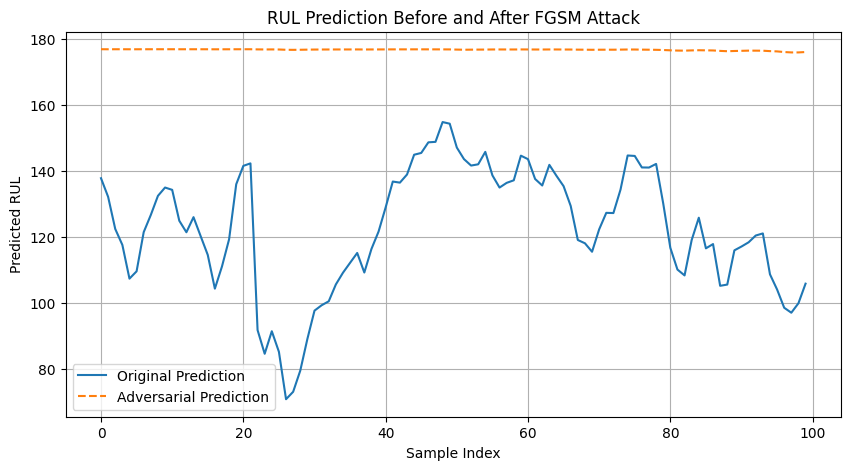

In [103]:
#Step 5: Visualize Perturbation Impact
plt.figure(figsize=(10, 5))
plt.plot(lstm_pred_orig, label='Original Prediction')
plt.plot(lstm_pred_adv, label='Adversarial Prediction', linestyle='--')
plt.title("RUL Prediction Before and After FGSM Attack")
plt.xlabel("Sample Index")
plt.ylabel("Predicted RUL")
plt.legend()
plt.grid(True)
plt.show()

In [104]:
#Step 6: Measure Perturbation Strength (Lp Norm)
from numpy.linalg import norm

l2_norms = [norm((x_adv - x_orig).flatten(), ord=2) for x_adv, x_orig in zip(X_adv, X_test[:100])]
print("Avg L2 perturbation:", np.mean(l2_norms))

Avg L2 perturbation: 0.9874210793145355


<br><br><br>
# **Investigating GRU on Perturbed Points**

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


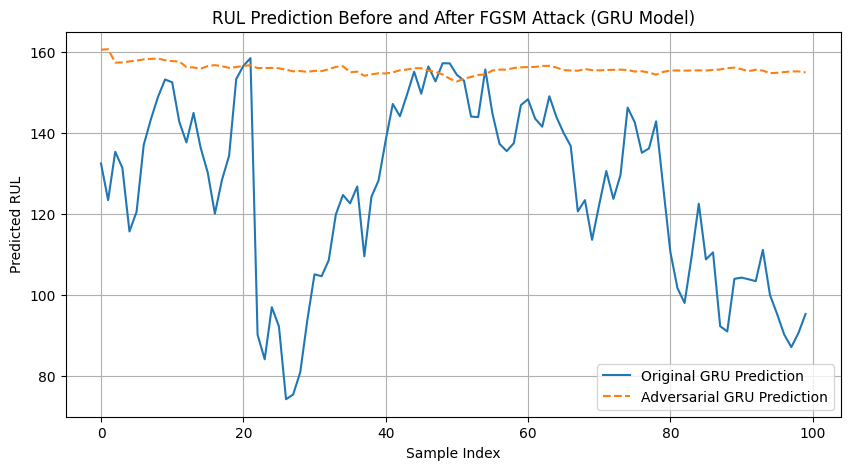

GRU Avg L2 perturbation: 0.9874210793145355


In [105]:
# Predict and compare
gru_pred_orig = gru_model.predict(X_test[:100])
gru_pred_adv = gru_model.predict(X_adv)

# Visualize attack impact on GRU model
plt.figure(figsize=(10, 5))
plt.plot(gru_pred_orig, label='Original GRU Prediction')
plt.plot(gru_pred_adv, label='Adversarial GRU Prediction', linestyle='--')
plt.title("RUL Prediction Before and After FGSM Attack (GRU Model)")
plt.xlabel("Sample Index")
plt.ylabel("Predicted RUL")
plt.legend()
plt.grid(True)
plt.show()

# Calculate GRU model perturbation strength
l2_norms_gru = [norm((x_adv - x_orig).flatten(), ord=2) for x_adv, x_orig in zip(X_adv, X_test[:100])]
print("GRU Avg L2 perturbation:", np.mean(l2_norms_gru))

<br><br><br>
# **Tranferibility Conclusion**

In [106]:
# Calculate impact metrics for both models
def calculate_attack_impact(orig_preds, adv_preds):
    # Mean Absolute Difference between original and adversarial predictions
    mean_abs_diff = np.mean(np.abs(orig_preds - adv_preds))
    
    # Percentage of samples where prediction changed significantly (>10%)
    significant_changes = np.mean(np.abs(orig_preds - adv_preds) > 0.1 * orig_preds) * 100
    
    # Mean percentage change in prediction
    mean_pct_change = np.mean(np.abs(orig_preds - adv_preds) / (orig_preds + 1e-10)) * 100
    
    return mean_abs_diff, significant_changes, mean_pct_change

# Calculate impact metrics
lstm_impact = calculate_attack_impact(lstm_pred_orig, lstm_pred_adv)
gru_impact = calculate_attack_impact(gru_pred_orig, gru_pred_adv)

print("Attack Impact on LSTM (source model):")
print(f"  Mean Absolute Difference: {lstm_impact[0]:.3f}")
print(f"  Samples with >10% change: {lstm_impact[1]:.1f}%")
print(f"  Mean Percentage Change: {lstm_impact[2]:.1f}%")

print("\nAttack Transferability to GRU (target model):")
print(f"  Mean Absolute Difference: {gru_impact[0]:.3f}")
print(f"  Samples with >10% change: {gru_impact[1]:.1f}%") 
print(f"  Mean Percentage Change: {gru_impact[2]:.1f}%")

# Calculate transferability success rate
transferability_rate = (gru_impact[0] / lstm_impact[0]) * 100
print(f"\nTransferability Success Rate: {transferability_rate:.1f}%")

Attack Impact on LSTM (source model):
  Mean Absolute Difference: 54.255
  Samples with >10% change: 100.0%
  Mean Percentage Change: 48.2%

Attack Transferability to GRU (target model):
  Mean Absolute Difference: 30.198
  Samples with >10% change: 70.0%
  Mean Percentage Change: 28.4%

Transferability Success Rate: 55.7%
